In [24]:
%matplotlib inline
from pylab import *
import emcee 
import corner
from scipy.io import loadmat
rcParams['font.size'] = 16

In [25]:
'''
For each variable, if its dimension is...
26... it is an event index (26 events total)
4096... it is a temporal index (for the time-domain reconstructed pulse profile; each sample=~5ns)
512... it is an input index (256 antennas, alternating inputs are different polarizations for the same antenna
/nan/ means "no data", usually because I didn't have enough network bandwidth to grab those samples :-/

Variables:

powsAll ->  peak power for each input

antPos2->  antenna positions in the [N/S, E/W, Up/Dn] direction; meters; referenced to center of array core

ipdAll ->  logical array; '1' if event timing was not an outlier in a plane wave source hypothesis (sorry for the shit name)

refAll ->  reconstructed pulse profile for each event.  All inputs averaged after considering geometric and cable delays, regardless of input health (after rejecting the banned inputs)

aerAll ->  az/el/range (degrees, degrees, meters) fit for each event

tpjAll ->  arrival time (in samples) of the peak power for each event, each input

efcAll ->  fitting error for the given az/el/range hypothesis, uses *only* the data from ipdAll, tpjAll, bannedInds

igAll ->  logical array; '1' if I got any data at all for that input... basically only '0' if I ran out of networking bandwidth

bi2 ->  list of inputs for which I discard all data, for the purposes of beam pattern fitting.

indsGood ->  Each event you see has a unique ID ->  {0, 3.6M}.  These are the unique IDs of each event in your personal dataset, which can be referenced to that dropbox link I provided you for visualization sake.  The fits listed here are overlaid there, too!

ig2 ->  of the events in this dataset, which do I think are cosmic rays?  These seven.  There are two more that *might* be cosmic rays.  I wonder if you can find them ;-)

x2 ->  fitting results for each event.  [gaussian amplitude, y0, x0, gaussian width, DC_offset_val, fraction_of_power_found_in_gaussian]

'''

'\nFor each variable, if its dimension is...\n26... it is an event index (26 events total)\n4096... it is a temporal index (for the time-domain reconstructed pulse profile; each sample=~5ns)\n512... it is an input index (256 antennas, alternating inputs are different polarizations for the same antenna\n/nan/ means "no data", usually because I didn\'t have enough network bandwidth to grab those samples :-/\n\nVariables:\n\npowsAll ->  peak power for each input\n\nantPos2->  antenna positions in the [N/S, E/W, Up/Dn] direction; meters; referenced to center of array core\n\nipdAll ->  logical array; \'1\' if event timing was not an outlier in a plane wave source hypothesis (sorry for the shit name)\n\nrefAll ->  reconstructed pulse profile for each event.  All inputs averaged after considering geometric and cable delays, regardless of input health (after rejecting the banned inputs)\n\naerAll ->  az/el/range (degrees, degrees, meters) fit for each event\n\ntpjAll ->  arrival time (in samp

In [45]:
'''
USE THE INFORMATION BELOW TO IDENTIFY RYAN'S COSMIC RAY CANDIDATES
'''
dat = loadmat('dataARW.mat')
for key in dat.keys():
    print key
print dat['bi2']
print dat['ipdAll']
print 'entry\taz\tel\trange'
print '----------------------------------'
for k in range(len(dat['aerAll'])):
    print k ,'\t%1.2f'%dat['aerAll'][k][0], '\t%1.2f'%dat['aerAll'][k][1], '\t%1.2f'%dat['aerAll'][k][2]
print 'y0, x0'
print '----------------------------------'
for k in range(len(dat['x2'])):
    print k ,'\t%1.2f'%dat['x2'][k][1], '\t%1.2f'%dat['x2'][k][2]
    
    

refAll
ig2
aerAll
x2
efcAll
__header__
powsAll
__globals__
igAll
ipdAll
tpjAll
antPos2
indsGood
__version__
bi2
[[493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510
  511 512 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128
  241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 369 370
  371 372 373 374 375 376 377 378 379 380 381 382 383 384 477 478 479 480
  481 482 483 484 485 486 487 488 489 490 491 492 210 210 212 212 358 450
  211 211 213 213 359 451]]
[0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 1
 0 1 0 0 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 1 0 1 0
 1 0 0 0 0 0 1 0 1 0 0 0 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1
 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 1 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 1 0 0 0

In [38]:
def read_event(entry, dat):
    evn = entry
    ant_x = dat['antPos2'][::2,0]
    ant_y = dat['antPos2'][::2,1]
    ant_z = dat['antPos2'][::2,2]
    pows = dat['powsAll'][:,evn]
    pows_1 = pows[::2]
    pows_2 = pows[1::2]
    times = dat['tpjAll'][:,evn]
    time_1 = times[::2]
    time_2 = times[1::2]

    # load ref_gains
    refgains = []
    for line in file('refgains.txt'):
        refgains.append(float(line))
    refg_1 = np.array(refgains[::2])
    refg_2 = np.array(refgains[1::2])
    
    return ant_x, ant_y, ant_z, pows_1, refg_1, time_1, pows_2, refg_2, time_2 

def plot_event(ant_x, ant_y, ant_z, pows_x, refg_x, time_x, pows_y, refg_y, time_y, cluster=False):
    '''
    cut_x = pows_x == pows_x
    cut_y = pows_y == pows_y
    med_p = np.median(np.log10(np.concatenate([pows_x[cut_x], pows_y[cut_y]])))
    MAD_p = np.median(np.abs(np.log10(np.concatenate([pows_x[cut_x], pows_y[cut_y]])) - med_p))
    med_t = np.median((np.concatenate([time_x, time_y])))
    MAD_t = np.median(np.abs((np.concatenate([time_x, time_y])) - med_t))
    med_p_x = np.median(np.log10(pows_x))
    MAD_p_x = np.median(np.abs(np.log10(pows_x[cut_x]) - med_p_x))
    med_p_y = np.median(np.log10(pows_y[cut_y]))
    MAD_p_y = np.median(np.abs(np.log10(pows_y[cut_y]) - med_p_y))
    
    qcut_x = np.logical_and(np.abs(time_x - med_t)< 3.*MAD_t, np.abs(np.log10(pows_x) - med_p_x)< 3.*MAD_p_x)
    qcut_y = np.logical_and(np.abs(time_y - med_t)< 3.*MAD_t, np.abs(np.log10(pows_y) - med_p_y)< 3.*MAD_p_y)
    Nqcut_x = np.logical_or(np.abs(time_x - med_t)> 3.*MAD_t, np.abs(np.log10(pows_x) - med_p_x)> 3.*MAD_p_x)
    Nqcut_y = np.logical_or(np.abs(time_y - med_t)> 3.*MAD_t, np.abs(np.log10(pows_y) - med_p_y)> 3.*MAD_p_y)
    '''
    cut_x = pows_x == pows_x
    cut_y = pows_y == pows_y
    rad = np.sqrt(ant_x**2 + ant_y**2)
    cut_x = np.logical_and(cut_x, rad<110.)
    cut_y = np.logical_and(cut_y, rad<110.)

    # cut based on MAD power
    med_p = np.median(np.log10(np.concatenate([pows_x[cut_x], pows_y[cut_y]])))
    MAD_p = np.median(np.abs(np.log10(np.concatenate([pows_x[cut_x], pows_y[cut_y]])) - med_p))

    med_t = np.median((np.concatenate([time_x[cut_x], time_y[cut_y]])))
    MAD_t = np.median(np.abs((np.concatenate([time_x[cut_x], time_y[cut_y]])) - med_t))
    med_p_x = np.median(np.log10(pows_x[cut_x]))
    MAD_p_x = np.median(np.abs(np.log10(pows_x[cut_x]) - med_p_x))
    med_p_y = np.median(np.log10(pows_y[cut_y]))
    MAD_p_y = np.median(np.abs(np.log10(pows_y[cut_y]) - med_p_y))

    t_cut_x = np.abs(np.where(cut_x, time_x, med_t) - med_t)< 3.*MAD_t
    t_cut_y = np.abs(np.where(cut_y, time_y, med_t) - med_t)< 3.*MAD_t

    #print 'self.pows_x', self.pows_x
    #print 'np.where(qcut_x)', np.where(cut_x, self.pows_x, med_p_x)

    p_cut_x = np.abs(np.log10(np.where(cut_x, pows_x, med_p_x)) - med_p_x)< 3.*MAD_p_x
    p_cut_y = np.abs(np.log10(np.where(cut_y, pows_y, med_p_y)) - med_p_y)< 3.*MAD_p_y

    qcut_x = np.logical_and( cut_x, p_cut_x)
    qcut_x = np.logical_and(qcut_x, t_cut_x)

    qcut_y = np.logical_and( cut_y, p_cut_y)
    qcut_y = np.logical_and(qcut_y, t_cut_y)

    Nqcut_x = np.invert(qcut_x)
    Nqcut_y = np.invert(qcut_y)
    
    figure(figsize = (12,8))
    subplot(221)
    scatter(ant_x[qcut_x], ant_y[qcut_x], c=np.log10(pows_x[qcut_x]/refg_x[qcut_x]), cmap='jet', vmin=0., vmax = 1.0)
    colorbar()
    scatter(ant_x[Nqcut_x], ant_y[Nqcut_x], c=np.log10(pows_x[Nqcut_x]/refg_x[Nqcut_x]), 
            marker = '+', s=80, linewidths=1,  cmap='jet', vmin=0., vmax = 1.0)
    subplot(222)
    scatter(ant_x[qcut_y], ant_y[qcut_y], c=np.log10(pows_y[qcut_y]/refg_y[qcut_y]), cmap='jet', vmin=0., vmax = 1.0)
    colorbar()
    scatter(ant_x[Nqcut_y], ant_y[Nqcut_y], c=np.log10(pows_y[Nqcut_y]/refg_y[Nqcut_y]), 
            marker = '+', s=80, linewidths=1,  cmap='jet', vmin=0., vmax = 1.0)
    subplot(223)
    scatter(ant_x[qcut_x], ant_y[qcut_x], c=time_x[qcut_x], cmap='jet', vmin=med_t-3.*MAD_t, vmax = med_t+3.*MAD_t)
    colorbar()
    scatter(ant_x[Nqcut_x], ant_y[Nqcut_x], c=time_x[Nqcut_x], 
            marker = '+', s=80, linewidths=1,  cmap='jet', vmin=med_t-3.*MAD_t, vmax = med_t+3.*MAD_t)
    subplot(224)
    scatter(ant_x[qcut_y], ant_y[qcut_y], c=time_y[qcut_y], cmap='jet', vmin=med_t-3.*MAD_t, vmax = med_t+3.*MAD_t)
    colorbar()
    scatter(ant_x[Nqcut_y], ant_y[Nqcut_y], c=time_x[Nqcut_y], 
            marker = '+', s=80, linewidths=1,  cmap='jet', vmin=med_t-3.*MAD_t, vmax = med_t+3.*MAD_t)
    if cluster == True:
        subplot(221)
        xlim(-110., 110.)
        ylim(-110., 110.)
        subplot(222)
        xlim(-110., 110.)
        ylim(-110., 110.)
        subplot(223)
        xlim(-110., 110.)
        ylim(-110., 110.)
        subplot(224)
        xlim(-110., 110.)
        ylim(-110., 110.)
        
    figure(figsize = (10,5))
    subplot(211)
    semilogx(np.sqrt(ant_x**2 + ant_y**2), np.log10(pows_x/refg_x), 'b.')
    semilogx(np.sqrt(ant_x[qcut_x]**2 + ant_y[qcut_x]**2), np.log10(pows_x[qcut_x]/refg_x[qcut_x]), 
             'o', ms=8, mfc='none', mew=1, mec='b')
    plot(np.sqrt(ant_x**2 + ant_y**2), np.log10(pows_y/refg_y), 'r.')
    semilogx(np.sqrt(ant_x[qcut_y]**2 + ant_y[qcut_y]**2), np.log10(pows_y[qcut_y]/refg_y[qcut_y]), 
             'o', ms=8, mfc='none', mew=1, mec='r')
    subplot(212)
    semilogx(np.sqrt(ant_x**2 + ant_y**2), time_x, 'b.')
    semilogx(np.sqrt(ant_x[qcut_x]**2 + ant_y[qcut_x]**2), time_x[qcut_x], 
             'o', ms=8, mfc='none', mew=1, mec='b')
    plot(np.sqrt(ant_x**2 + ant_y**2), time_y, 'r.')
    semilogx(np.sqrt(ant_x[qcut_y]**2 + ant_y[qcut_y]**2), time_y[qcut_y], 
             'o', ms=8, mfc='none', mew=1, mec='r')
    
    print 'MAD_p_x, med_p_x', MAD_p_x, med_p_x 
    print 'MAD_p_y, med_p_y', MAD_p_y, med_p_y 

MAD_p_x, med_p_x 0.149125913945 2.57475314855
MAD_p_y, med_p_y 0.124549079787 2.19997645793


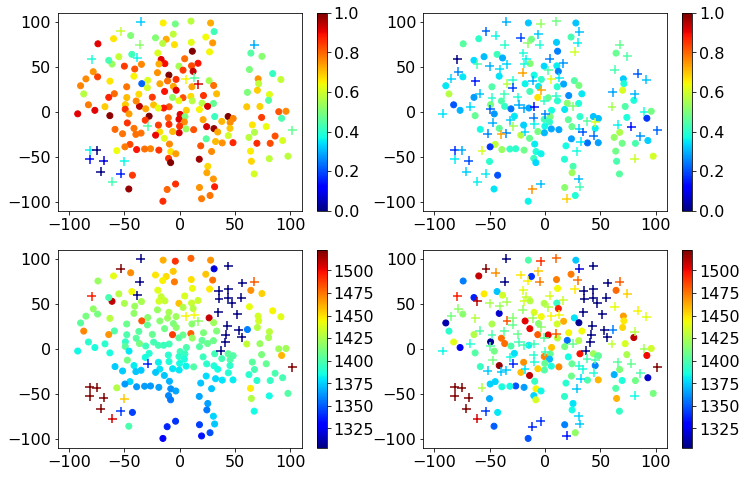

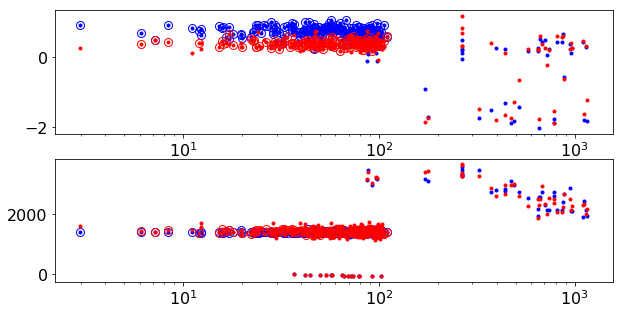

In [39]:
#evnum = 19, this is a CR event
evnum = 21
ant_x, ant_y, ant_z, pows_x, refg_x, time_x, pows_y, refg_y, time_y = read_event(evnum, dat)
plot_event(ant_x, ant_y, ant_z, pows_x, refg_x, time_x, pows_y, refg_y, time_y, cluster=True)

aerAll [  2.02325173e+02   3.37470111e+01   1.00000885e+06]
zen_deg, phi_deg, x_core, y_core, log10_proton_energy
56.2529889005 22.3251733812 -0.00446109147056 0.0887969286229 18.0


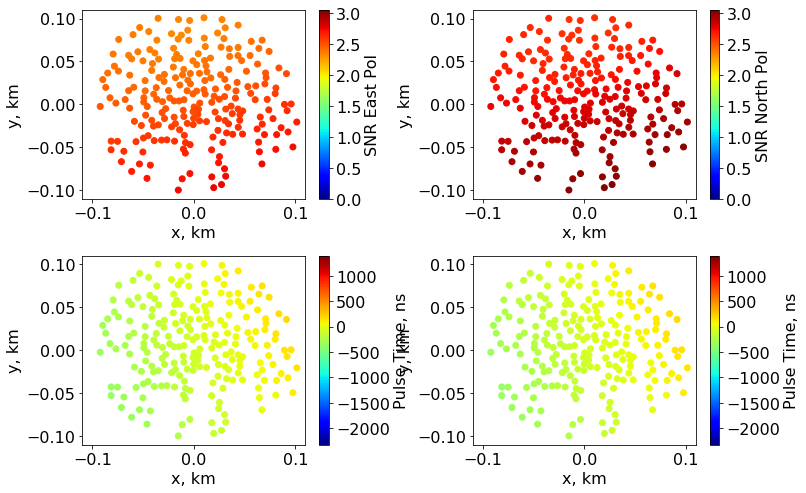

In [6]:
'''
Set up the model
'''
# inputs
#axis: zen, phi, x_core, y_core
#energy: zen, phi, x_core, y_core
# create instance of geometry class with one event and fill in the parameters by hand
from geometry import Geometry
from xmax_calc import Xmax_calc
from detector_array import Detector_Array
from radio_emission import Radio_Emission
from detector import Detector

# maybe faster if this is a class function
def model(zen_deg, phi_deg, x_core, y_core, log10_proton_energy, show_plot=False):
    geom = Geometry(1., 1, zen_angle_deg = None)
    XMC = Xmax_calc()
    det_arr = Detector_Array(mode='Ryan')
    rad_em = Radio_Emission()
    det = Detector()
    
    geom.zen_angle_deg = zen_deg
    geom.x_pos[0]   = x_core
    geom.y_pos[0]   = y_core
    geom.z_pos[0]   = 1.222
    geom.cos_th_CR[0] = np.cos(zen_deg * pi/180.)
    geom.phi_CR[0]    = phi_deg * pi/180.
    geom.k_x[0]       = np.sqrt(1.-geom.cos_th_CR**2)*np.cos(geom.phi_CR)
    geom.k_y[0]       = np.sqrt(1.-geom.cos_th_CR**2)*np.sin(geom.phi_CR)
    geom.k_z[0]       = geom.cos_th_CR
    XMC.get_Xmax_position(log10_proton_energy, geom)
    det_arr.get_distances_and_view_angles(XMC, geom, event=0)

    E_field,dist = rad_em.radio_beam_model2(zen_deg, det_arr.th_view, 1.2) # 1.2 is the altitude
    E_field *= 10**(log10_proton_energy-17.)
        
    x_pol, y_pol, z_pol = rad_em.get_pol(XMC.x_max[0],  XMC.y_max[0],  XMC.z_max[0]-XMC.Earth_radius,
                                         geom.x_pos[0], geom.y_pos[0], geom.z_pos[0])
    
    V_x = det.Efield_2_Voltage(np.array(E_field*x_pol), zen_deg)
    V_y = det.Efield_2_Voltage(np.array(E_field*y_pol), zen_deg)
    V_z = det.Efield_2_Voltage(np.array(E_field*z_pol), zen_deg)

    SNR_x = np.abs(V_x)/det.V_rms
    SNR_y = np.abs(V_y)/det.V_rms

    b_x, b_y, b_z = det_arr.x - geom.x_pos[0], det_arr.y - geom.y_pos[0], det_arr.z - geom.z_pos[0]
    c_km_per_ns = 0.299792*1.e-3
    plane_wave_delays = (b_x * geom.k_x[0] + b_y * geom.k_y[0] + b_z * geom.k_z[0]) / c_km_per_ns
    # need to return SNR cut, have to figure out if antenna list matches Ryan's format (can fix)
    #plane_wave_delays -= timing_offset
    max_val = np.max(np.concatenate([SNR_x, SNR_y]))
    max_val = np.log10(max_val**2)
    
    if show_plot:
        #print max_val
        figure(figsize=(12,8))
        subplot(221)
        plot(det_arr.x[SNR_x<=5.], det_arr.y[SNR_x<=5.], 'o', color='0.8')
        scatter(det_arr.x[SNR_x>5.], det_arr.y[SNR_x>5.], c=np.log10(SNR_x[SNR_x>5.]**2), cmap='jet', vmin=0., vmax = max_val)
        xlim(-0.11, 0.11)
        ylim(-0.11, 0.11)
        colorbar(label=r'SNR East Pol')
        xlabel('x, km')
        ylabel('y, km')

        subplot(222)
        plot(det_arr.x[SNR_y<=5.], det_arr.y[SNR_y<=5.], 'o', color='0.8')
        scatter(det_arr.x[SNR_y>5.], det_arr.y[SNR_y>5.], c=np.log10(SNR_y[SNR_y>5.]**2), cmap='jet', vmin=0., vmax = max_val)
        xlim(-0.11, 0.11)
        ylim(-0.11, 0.11)
        colorbar(label=r'SNR North Pol')
        xlabel('x, km')
        ylabel('y, km')

        subplot(223)
        plot(det_arr.x[SNR_x<=5.], det_arr.y[SNR_x<=5.], 'o', color='0.8')
        scatter(det_arr.x[SNR_x>5.], det_arr.y[SNR_x>5.], c=plane_wave_delays[SNR_x>5.], cmap='jet')
        xlim(-0.11, 0.11)
        ylim(-0.11, 0.11)
        colorbar(label=r'Pulse Time, ns')
        xlabel('x, km')
        ylabel('y, km')

        subplot(224)
        plot(det_arr.x[SNR_y<=5.], det_arr.y[SNR_y<=5.], 'o', color='0.8')
        scatter(det_arr.x[SNR_y>5.], det_arr.y[SNR_y>5.], c=plane_wave_delays[SNR_y>5.], cmap='jet')
        xlim(-0.11, 0.11)
        ylim(-0.11, 0.11)
        colorbar(label=r'Pulse Time, ns')
        xlabel('x, km')
        ylabel('y, km')

        subplots_adjust(wspace=0.4, hspace=0.3)
    return np.log10(SNR_x**2), np.log10(SNR_y**2), plane_wave_delays

print 'aerAll', dat['aerAll'][evnum]
zen_deg = 90. - np.abs(dat['aerAll'][evnum][1])
phi_deg = mod(180 + dat['aerAll'][evnum][0], 360.)
#phi_deg = dat['aerAll'][evnum][0]
#print 'phi_deg', phi_deg
x_core = dat['x2'][evnum][1]*1.e-3
y_core = dat['x2'][evnum][2]*1.e-3
log10_proton_energy = 18.
#scaling_factor = 1.
#timing_offset=-300.
print 'zen_deg, phi_deg, x_core, y_core, log10_proton_energy'
print zen_deg, phi_deg, x_core, y_core, log10_proton_energy
log10_pow_x, log10_pow_y, delays = model(zen_deg, phi_deg, x_core, y_core, log10_proton_energy, show_plot=True)

In [7]:
pow_x, pow_y, delays = model(zen_deg, phi_deg, x_core, y_core, log10_proton_energy)

In [8]:
def lnlike(theta, data, data_err):
    zen_deg, phi_deg, x_core, y_core, log10_proton_energy, scaling_factor, timing_offset = theta
    log10_snr_x, log10_snr_y, delays = model(zen_deg, phi_deg, x_core, y_core, log10_proton_energy)
    ant_x, ant_y, ant_z, pows_1, time_1, pows_2, time_2, qcut_x, qcut_y = data
    pow_x_err, pow_y_err, time_x_err, time_y_err = data_err
    #return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))
    check_cut_x = log10_snr_x > np.log10(5.**2)
    check_cut_y = log10_snr_y > np.log10(5.**2)
    #if np.max([np.max(log10_snr_x),np.max(log10_snr_y)])<np.log10(5.**2):
    if np.sum(check_cut_x) + np.sum(check_cut_x) < 12:
        return -np.inf
    ll  = -0.5*(np.sum((pows_1[qcut_x] - log10_snr_x[qcut_x] - scaling_factor)**2/(pow_x_err[qcut_x])**2))
    ll += -0.5*(np.sum((pows_2[qcut_y] - log10_snr_y[qcut_y] - scaling_factor)**2/(pow_y_err[qcut_y])**2))
    ll += -0.5*(np.sum((5.*time_1[qcut_x] - delays[qcut_x] - timing_offset)**2/(time_x_err[qcut_x])**2))
    ll += -0.5*(np.sum((5.*time_2[qcut_y] - delays[qcut_y] - timing_offset)**2/(time_y_err[qcut_y])**2))
    return ll

def lnprior(theta):
    zen_deg, phi_deg, x_core, y_core, log10_proton_energy, scaling_factor, timing_offset = theta
    if  (zen_deg>0. and zen_deg<90.) \
    and (phi_deg>-30. and phi_deg<390.) \
    and (log10_proton_energy>16. and log10_proton_energy<19.):
        return 0.
    #print 'theta', theta
    #print 'returning inf!'
    return -np.inf

def lnprob(theta, data, data_err):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, data, data_err)


/Users/romerowo/anaconda/lib/python2.7/site-packages/numpy/lib/function_base.py:3142: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


sum(qcut_x), sum(qcut_y) 0 170
scaling_factor_0 1.0281442693


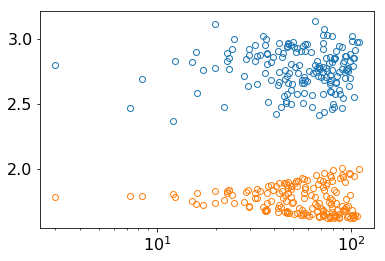

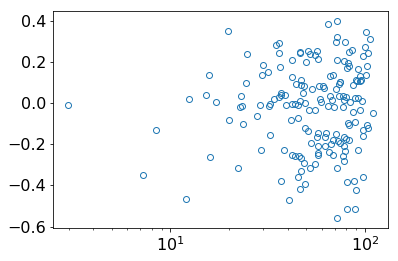

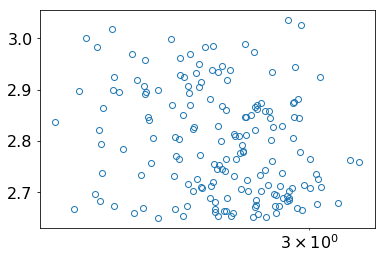

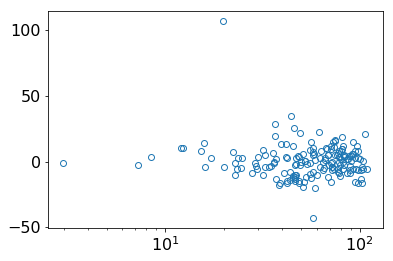

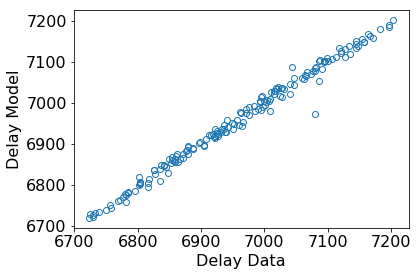

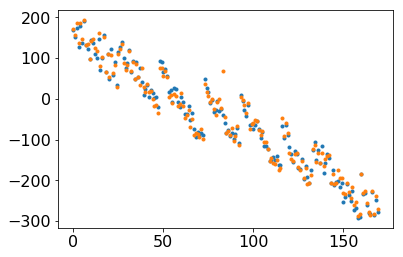

In [9]:
#ant_x, ant_y, ant_z, pows_x, time_x, pows_y, time_y = read_event(evnum, dat)

# quality cuts
rad = np.sqrt(ant_x**2 + ant_y**2)
cut_x = np.logical_and(pows_x == pows_x, rad<110.)
cut_y = np.logical_and(pows_y == pows_y, rad<110.)
med_p = np.median(np.log10(np.concatenate([pows_x[cut_x], pows_y[cut_y]])))
MAD_p = np.median(np.abs(np.log10(np.concatenate([pows_x[cut_x], pows_y[cut_y]])) - med_p))
med_t_x = np.median(time_x)
MAD_t_x = np.median(np.abs(time_x - med_t_x))
med_t_y = np.median(time_y)
MAD_t_y = np.median(np.abs(time_y - med_t_y))
med_p_x = np.median(np.log10(pows_x))
MAD_p_x = np.median(np.abs(np.log10(pows_x[cut_x]) - med_p_x))
med_p_y = np.median(np.log10(pows_y[cut_y]))
MAD_p_y = np.median(np.abs(np.log10(pows_y[cut_y]) - med_p_y))


cut_pow_x = np.zeros((len(pow_x)), dtype = bool)
cut_pow_y = np.zeros((len(pow_x)), dtype = bool)
cut_time_x = np.zeros((len(pow_x)), dtype = bool)
cut_time_y = np.zeros((len(pow_x)), dtype = bool)
for k in range(len(ant_x)):
    if cut_x[k]:
        cut_pow_x[k]  = np.abs(np.log10(pows_x[k]) - med_p_x)< 3.*MAD_p_x
        cut_time_x[k] = np.abs(time_x[k] - med_t_x)< 3.*MAD_t_x
    if cut_y[k]:
        cut_pow_y[k]  = np.abs(np.log10(pows_y[k]) - med_p_y)< 3.*MAD_p_y
        cut_time_y[k] = np.abs(time_y[k] - med_t_y)< 3.*MAD_t_y
qcut_x = np.logical_and(cut_pow_x, cut_time_x)
qcut_y = np.logical_and(cut_pow_y, cut_time_y)


data = [ant_x, ant_y, ant_z, np.log10(pows_x), time_x, np.log10(pows_y), time_y, qcut_x, qcut_y]
pow_x_err = 0.3*np.ones(len(ant_x))
pow_y_err = 0.3*np.ones(len(ant_x)) 
time_x_err = 5.*np.ones(len(ant_x))
time_y_err = 5.*np.ones(len(ant_x))
data_err = [pow_x_err, pow_y_err, time_x_err, time_y_err]

ndim, nwalkers = 7, 100
'''
zen_deg = 90. - dat['aerAll'][evnum][1]
phi_deg = mod(180 + dat['aerAll'][evnum][0], 360.)
#print 'phi_deg', phi_deg
x_core = dat['x2'][evnum][1]*1.e-3
y_core = dat['x2'][evnum][2]*1.e-3
log10_proton_energy = 17.2
'''

zen_deg_0 = 90. - np.abs(dat['aerAll'][evnum][1])
phi_deg_0 = mod(180 + dat['aerAll'][evnum][0], 360.)
#phi_deg_0 = dat['aerAll'][evnum][0]
x_core_0 = dat['x2'][evnum][1]*1.e-3
y_core_0 = dat['x2'][evnum][2]*1.e-3
log10_proton_energy_0 = 17.5
#print '+',np.median(pows_x[qcut_x]),np.median(pows_y[qcut_y])
scaling_factor_0 = 0.
timing_offset_0  = 0.


log10_snr_x, log10_snr_y, delays = model(zen_deg_0, phi_deg_0, x_core_0, y_core_0, log10_proton_energy_0)

print 'sum(qcut_x), sum(qcut_y)', sum(qcut_x), sum(qcut_y)
if sum(qcut_x)>0 and sum(qcut_y)>0:
    scaling_factor_0 = np.max([np.median(np.log10(pows_x[qcut_x])-log10_snr_x[qcut_x]),np.median(np.log10(pows_y[qcut_y])-log10_snr_y[qcut_y])])
    timing_offset_0  = np.median(np.concatenate([5.*time_x[qcut_x]-delays[qcut_x], 5.*time_y[qcut_y]-delays[qcut_y]]))
if sum(qcut_y)==0:
    scaling_factor_0 = np.median(np.log10(pows_x[qcut_x])-log10_snr_x[qcut_x])
    timing_offset_0  = np.median(5.*time_x[qcut_x]-delays[qcut_x])
if sum(qcut_x)==0:
    scaling_factor_0 = np.median(np.log10(pows_y[qcut_y])-log10_snr_y[qcut_y])
    timing_offset_0  = np.median(5.*time_y[qcut_y]-delays[qcut_y])

par_0 = [zen_deg_0, phi_deg_0, x_core_0, y_core_0, log10_proton_energy_0, scaling_factor_0, timing_offset_0]


r = np.sqrt(ant_x**2 + ant_y**2)
#semilogx(r, np.log10(pows_y), '.')
semilogx(r[qcut_y], np.log10(pows_y)[qcut_y], 'o', mfc='none')
semilogx(r[qcut_y], log10_snr_y[qcut_y], 'o', mfc='none')

print 'scaling_factor_0', scaling_factor_0
figure()
semilogx(r[qcut_y], np.log10(pows_y)[qcut_y]-log10_snr_y[qcut_y]-scaling_factor_0, 'o', mfc='none')


figure()
semilogx(np.log10(pows_y)[qcut_y], log10_snr_y[qcut_y]+scaling_factor_0, 'o', mfc='none')

figure()
semilogx(r[qcut_y], 5.*time_y[qcut_y]-delays[qcut_y]-timing_offset_0, 'o', mfc='none')

figure()
plot(5.*time_y[qcut_y], delays[qcut_y]+timing_offset_0, 'o', mfc='none')
xlabel('Delay Data')
ylabel('Delay Model')
#print 'np.median(np.log10(pows_y[qcut_y]))', np.median(np.log10(pows_y[qcut_y]))
#print 'log10_snr_y[qcut_y]', log10_snr_y

figure()
#plot((delays[qcut_y]+timing_offset_0)/5., (time_y[qcut_y] - med_t_y)/MAD_t_y, '.')
plot(delays[qcut_y], '.')
plot(5.*time_y[qcut_y] - np.median(5.*time_y[qcut_y]-delays[qcut_y]), '.')
#print 'par_0', par_0
#print 'dat[\'x2\'][evnum]', dat['x2'][evnum]
#, time_x, pows_y, time_y)

In [10]:
'''
Minimize
'''
from scipy.optimize import minimize

def minus_lnprob(_parms):
    LL = lnprob(_parms, data, data_err)
    '''
    print_str = '%1.2e '%LL
    for k in range(0,len(_parms)):
        print_str += '%+1.1e '%_parms[k]
    # print the values occasionally
    if(np.random.randint(0,100)==0): print print_str
    '''
    return -1.*LL

parms_list = []
ll_val_list = []
#for trials in range(100):
print minus_lnprob(par_0)
max_loop = 5
success = False
loop_count = 0
parms = np.array(par_0).copy()
while success==False and loop_count < max_loop:
    print 'loop_count', loop_count
    res = minimize(minus_lnprob, parms, method='nelder-mead', options={'xtol': 1e-3, 'disp': True})
    parms = res.x
    success = res.success
    loop_count += 1


643.755811162
loop_count 0
Optimization terminated successfully.
         Current function value: 616.510933
         Iterations: 701
         Function evaluations: 1093


MAD_p_x, med_p_x 0.124862282616 2.68574253109
MAD_p_y, med_p_y 0.130066144924 2.76060771563
[  5.51649992e+01   2.26073764e+01  -1.29243140e-02  -1.80588913e-02
   1.79843709e+01   4.97277902e-02   6.87806189e+03]
[56.252988900469816, 22.325173381218974, -0.0044610914705648739, 0.088796928622905016, 17.5, 1.0281442692982496, 7011.0122968280903]


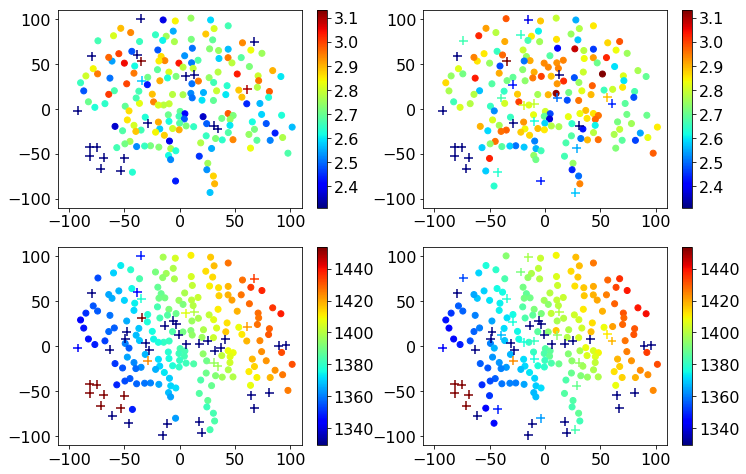

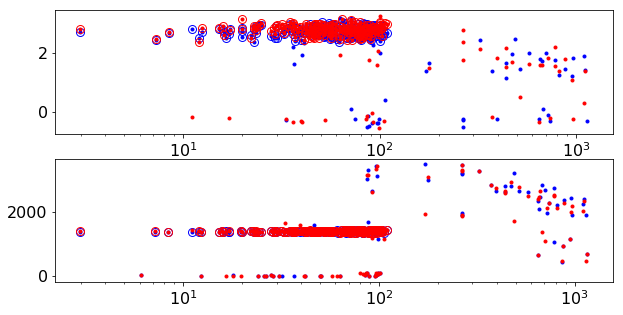

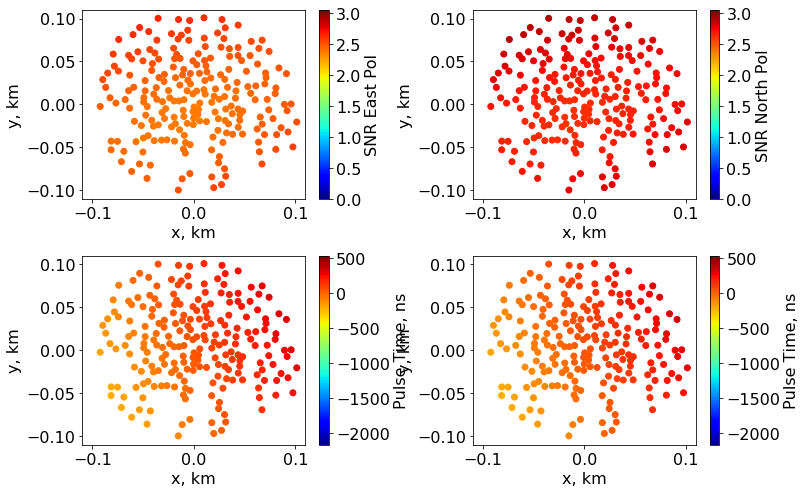

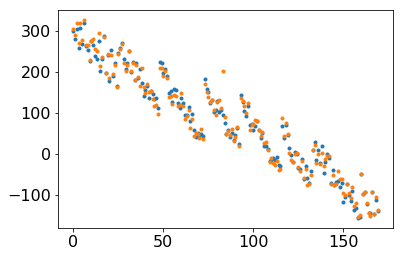

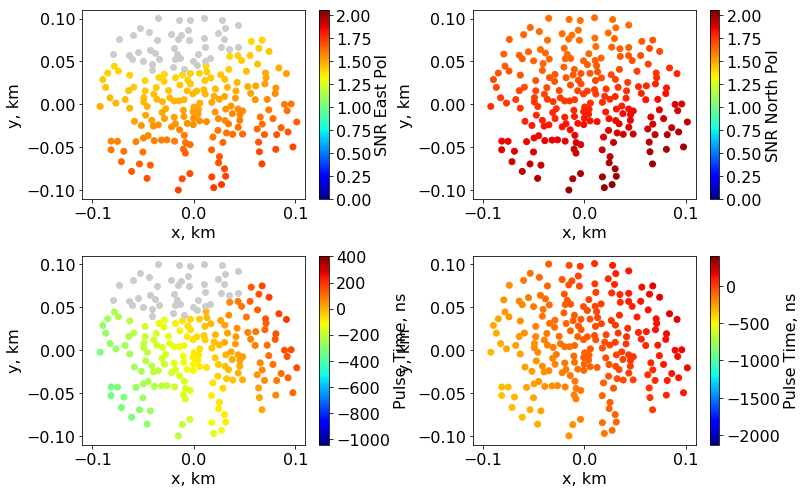

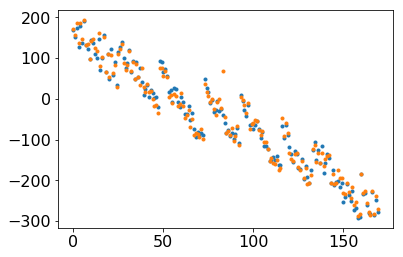

In [11]:
plot_event(ant_x, ant_y, ant_z, pows_x, time_x, pows_y, time_y, cluster=True)

print parms
print par_0
#mod_dat = model(parms[0], parms[1], parms[2], parms[3], parms[4], show_plot=True)
log10_snr_x, log10_snr_y, delays = model(parms[0], parms[1], parms[2], parms[3], parms[4], show_plot=True)


figure()
#plot(delays[qcut_y], time_y[qcut_y], '.')
plot(delays[qcut_y], '.')
plot(5.*time_y[qcut_y] - np.median(5.*time_y[qcut_y]-delays[qcut_y]), '.')

log10_snr_x, log10_snr_y, delays = model(par_0[0], par_0[1], par_0[2], par_0[3], par_0[4], show_plot=True)
#log10_snr_x, log10_snr_y, delays = model(parms[0], parms[1], parms[2], parms[3], parms[4])
#log10_snr_x, log10_snr_y, delays = model(par_0[0], par_0[1], par_0[2], par_0[3], par_0[4])

figure()
#plot(delays[qcut_y], time_y[qcut_y], '.')
plot(delays[qcut_y], '.')
plot(5.*time_y[qcut_y] - np.median(5.*time_y[qcut_y]-delays[qcut_y]), '.')


In [12]:
print 'par_0',par_0
#pos = [par_0 + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
pos = []
for i in range(nwalkers):
    vec = []
    for k in range(len(par_0)):
        #print k, par_0[k]
        if k not in [0, 1, 4]:
            vec.append(par_0[k] + np.random.uniform(par_0[k]*0.9,par_0[k]*1.1))
        if k in [0, 1, 4]:
            vec.append(par_0[k] + np.random.uniform(-0.1, 0.1))
    pos.append(vec)
#print 'pos',pos
#pos = [par_0 + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]


sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(data, data_err))

par_0 [56.252988900469816, 22.325173381218974, -0.0044610914705648739, 0.088796928622905016, 17.5, 1.0281442692982496, 7011.0122968280903]


In [13]:

ntrials = 1000
sampler.run_mcmc(pos, ntrials)

(array([[  5.52737026e+01,   2.23797458e+01,  -3.24627038e-01,
          -7.59888487e-02,   1.87796679e+01,  -1.81421990e+00,
           6.02790690e+03],
        [  5.56554550e+01,   2.29436230e+01,   2.83133002e-01,
           2.86383175e-01,   1.78570776e+01,   2.67284305e-02,
           7.95483149e+03],
        [  5.49181509e+01,   2.28162159e+01,  -5.72246829e-02,
          -6.77943364e-03,   1.74715404e+01,   1.05796303e+00,
           6.77791038e+03],
        [  5.55412188e+01,   2.25217507e+01,   1.19001156e-01,
           2.68263391e-01,   1.78710135e+01,  -3.02650258e-02,
           7.51534611e+03],
        [  5.51766939e+01,   2.27261011e+01,  -2.71030312e-01,
          -1.59963071e-01,   1.76396241e+01,   4.37941342e-01,
           6.07654252e+03],
        [  5.47406764e+01,   2.28114971e+01,  -8.08717479e-02,
          -1.96427930e-01,   1.82575540e+01,  -8.06976936e-01,
           6.51896910e+03],
        [  5.55266042e+01,   2.24715870e+01,  -1.96094897e-01,
          -1.

sampler.chain.shape (100, 1000, 7)
sampler.lnprobability.shape (100, 1000)
samples.shape, ll_vals.shape (50000, 7) (50000,)
54.1944241972 56.2488933065
21.8961246448 23.2886528557
-0.437548602241 0.423882591713
-0.247957371944 0.342349269942
17.2717766325 18.9996948477
-2.33150762728 1.42432850101
5695.2919729 8239.53907184
sampler.chain.shape (100, 1000, 7)
samples.shape (50000, 7)


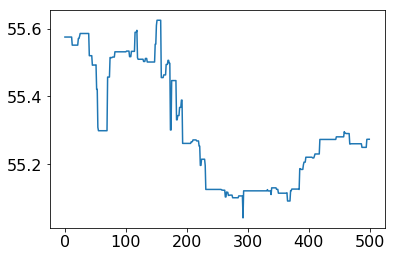

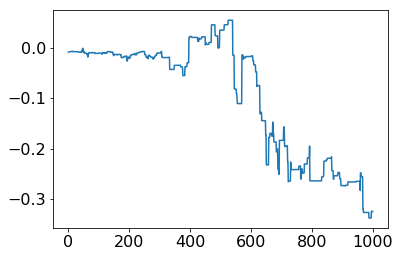

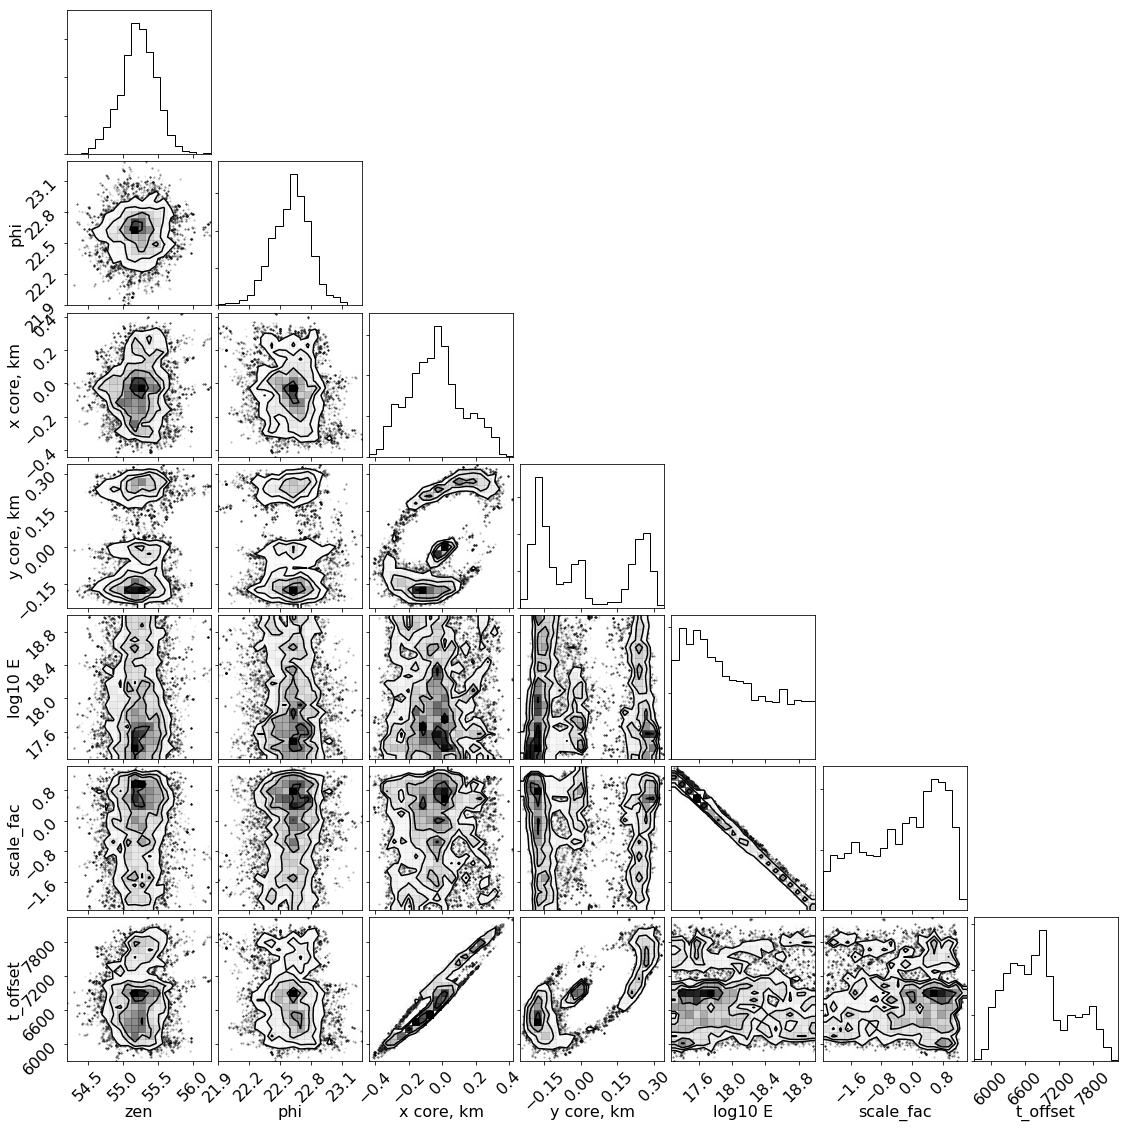

In [14]:
import corner
figure()
plot(sampler.chain[0,ntrials//2:,0], '-')
#plot(sampler.chain[1,:,0], '-')
#plot(sampler.chain[2,:,0], '-')
#plot(sampler.chain[3,:,0], '-')
#print sampler.chain[0,:,0]
samples = sampler.chain[:, ntrials//2:, :].reshape((-1, ndim))
print 'sampler.chain.shape', sampler.chain.shape
print 'sampler.lnprobability.shape', sampler.lnprobability.shape
ll_vals = sampler.lnprobability[:, ntrials//2:].reshape((-1))
print 'samples.shape, ll_vals.shape', samples.shape, ll_vals.shape
#samples = sampler.chain[:, 5000:, :].reshape((-1, ndim))

for k in range(ndim):
    print np.min(samples[:,k]), np.max(samples[:,k])

print 'sampler.chain.shape', sampler.chain.shape
print 'samples.shape', samples.shape
#import corner
figure()
#for k in range(0, len(sampler.chain)):
for k in range(0, 1):
    plot(sampler.chain[k,:,2])
'''
figure()
for k in np.random.randint(0, len(samples), 10):
    subplot(211)
    x0, y0, z0, a, b = samples[k,:]
    r2 = np.sqrt((x2-x0)**2 + (y2-y0)**2 + (z2-z0)**2)
    plot(r2, t2, 'o')
    plot(r2, hype(x_data, x0, y0, z0, a, b), '.', alpha=0.1)
    plot(r2, t2, 'kx', ms=10)
    subplot(212)
    plot(r2, hype(x_data, x0, y0, z0, a, b)-t2, '.', alpha=1.)
    #subplot(212)
    #plot([np.sum((hype(x_data, x0, y0, z0, a, b)-t2)**2)/float(len(t2)-5.)], '.')

figure()
plot(samples[:,0],samples[:,3], '.')
figure()
plot(samples[:,0],samples[:,4], '.')
#figure()
#hist(samples[:,1])
#figure()
#hist(samples[:,2])
#figure()
#hist(samples[:,3])
#figure()
#hist(samples[:,4])
'''
fig = corner.corner(samples, labels=['zen', 'phi', 'x core, km', 'y core, km', 'log10 E', 'scale_fac', 't_offset'])
#fig.savefig("triangle.png")

In [15]:
print par_0

[56.252988900469816, 22.325173381218974, -0.0044610914705648739, 0.088796928622905016, 17.5, 1.0281442692982496, 7011.0122968280903]


[  5.55748420e+01   2.26314267e+01   3.46416283e-02  -1.69739769e-01
   1.79302254e+01  -1.18385853e-01   6.83775820e+03]


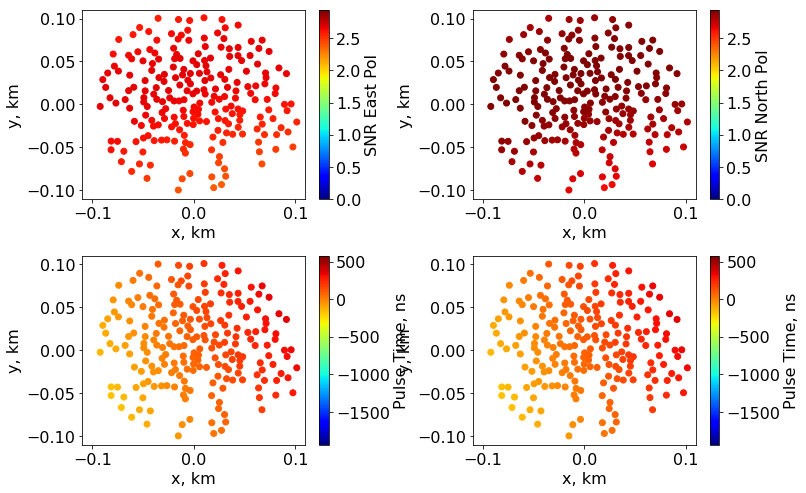

In [16]:
parms = samples[np.random.randint(0,len(samples)), :]
idx = np.argmax(ll_vals.shape)
parms = samples[idx, :]
print parms
log10_snr_x, log10_snr_y, delays = model(parms[0], parms[1], parms[2], parms[3], parms[4], show_plot=True)
#plot_event(ant_x, ant_y, ant_z, pows_x, time_x, pows_y, time_y, cluster=True)

parms[2], parms[3] 0.0346416283356 -0.169739768908
86.2999298259 278.884255554
parms[5] -0.118385853303
1.0281442693


/Users/romerowo/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/romerowo/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


post_t_med_x, post_t_MAD_x, 3.*t_RMS_x nan nan nan
post_t_med_y, post_t_MAD_y, 3.*t_RMS_y -0.60815811396 6.26110948928 46.413604644
[56.252988900469816, 22.325173381218974, -0.0044610914705648739, 0.088796928622905016, 17.5, 1.0281442692982496, 7011.0122968280903]
[  3.85389259e+02  -4.46109147e+00   8.87969286e+01   8.99999852e+01
   9.13845940e+02   1.86297943e-01]


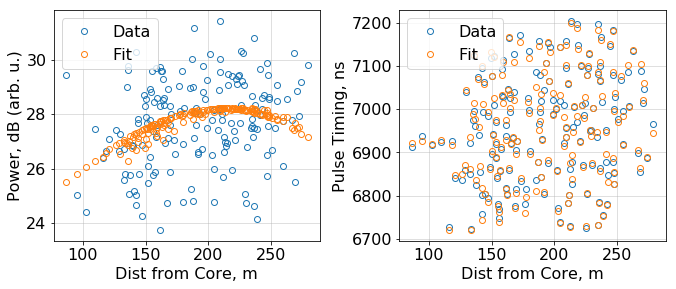

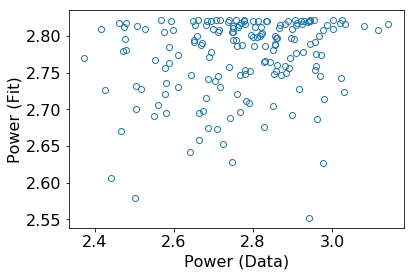

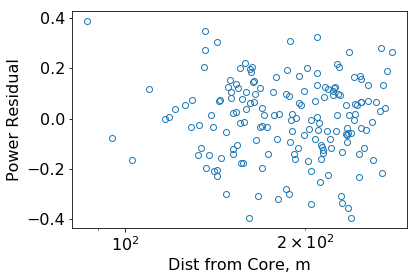

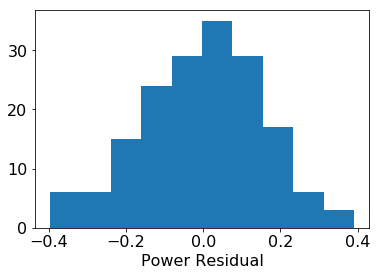

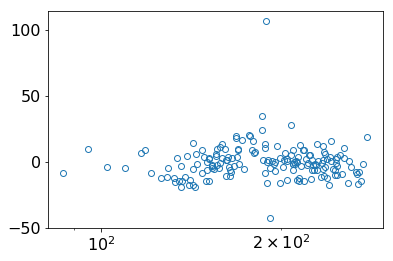

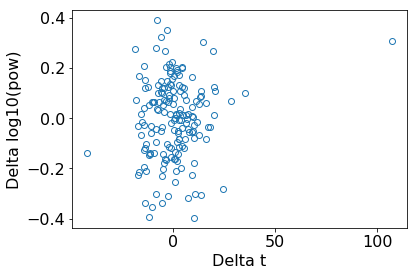

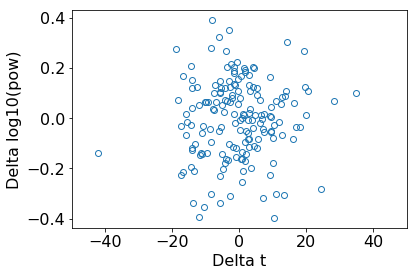

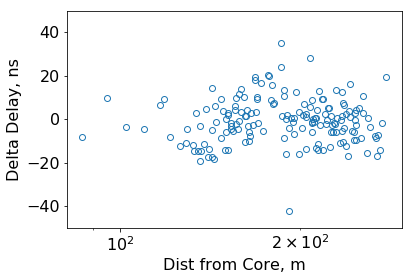

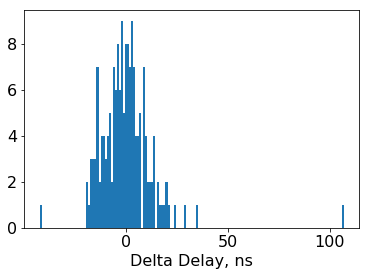

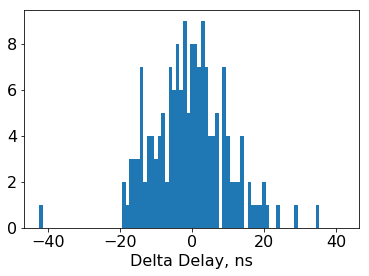

In [17]:
figure(figsize=(10,4))
subplot(121)
print 'parms[2], parms[3]', parms[2], parms[3]
r = np.sqrt((ant_x-parms[2]*1.e3)**2 + (ant_y-parms[3]*1.e3)**2)
#r = np.sqrt((ant_x)**2 + (ant_y)**2)
#semilogx(r, np.log10(pows_y), '.')
plot(r[qcut_y], 10.*np.log10(pows_y)[qcut_y], 'o', mfc='none', label='Data')
plot(r[qcut_y], 10.*(log10_snr_y[qcut_y]+parms[5]), 'o', mfc='none', label='Fit')
legend(loc=0)
#xticks([np.min(r[qcut_y]), np.max(r[qcut_y])])
grid(True, which='both', alpha=0.5)
xlabel('Dist from Core, m')
ylabel('Power, dB (arb. u.)')
#title('Event %d'%evnum)
print np.min(r[qcut_y]), np.max(r[qcut_y])
subplot(122)
plot(r[qcut_y], 5.*time_y[qcut_y], 'o', mfc='none', label='Data')
plot(r[qcut_y], delays[qcut_y]+parms[6], 'o', mfc='none', label='Fit')
legend(loc=0)
grid(True, which='both', alpha=0.5)
xlabel('Dist from Core, m')
ylabel('Pulse Timing, ns')
#title('Event %d'%evnum)
subplots_adjust(wspace=0.3, left=0.1, right=0.95, bottom=0.15, top=0.95)
savefig('event_%d_fit.pdf'%evnum)
#################################################################################
#################################################################################
#################################################################################

figure()
plot(np.log10(pows_y)[qcut_y], log10_snr_y[qcut_y]+parms[5], 'o', mfc='none')
ylabel('Power (Fit)')
xlabel('Power (Data)')
print 'parms[5]', parms[5]
print scaling_factor_0
figure()
semilogx(r[qcut_y], np.log10(pows_y)[qcut_y]-log10_snr_y[qcut_y]-parms[5], 'o', mfc='none')
xlabel('Dist from Core, m')
ylabel('Power Residual')

figure()
hist(np.log10(pows_y)[qcut_y]-log10_snr_y[qcut_y]-parms[5])
xlabel('Power Residual')


figure()
semilogx(r[qcut_y], 5.*time_y[qcut_y]-delays[qcut_y]-parms[6], 'o', mfc='none')

figure()
plot(5.*time_y[qcut_y]-delays[qcut_y]-parms[6], np.log10(pows_y)[qcut_y]-log10_snr_y[qcut_y]-parms[5], 'o', mfc='none')
xlabel('Delta t')
ylabel('Delta log10(pow)')

figure()
plot(5.*time_y[qcut_y]-delays[qcut_y]-parms[6], np.log10(pows_y)[qcut_y]-log10_snr_y[qcut_y]-parms[5], 'o', mfc='none')
xlabel('Delta t')
ylabel('Delta log10(pow)')
xlim(-50., 50.)


figure()
semilogx(r[qcut_y], 5.*time_y[qcut_y]-delays[qcut_y]-parms[6], 'o', mfc='none')
ylim(-50., 50.)
xlabel('Dist from Core, m')
ylabel('Delta Delay, ns')
figure()
hist(5.*time_y[qcut_y]-delays[qcut_y]-parms[6], bins=150)
xlabel('Delta Delay, ns')

post_t_med_x = np.median(5.*time_x[qcut_x]-delays[qcut_x]-parms[6])
post_t_MAD_x = np.median(np.abs(5.*time_x[qcut_x]-delays[qcut_x]-parms[6] - post_t_med_x))
post_t_med_y = np.median(5.*time_y[qcut_y]-delays[qcut_y]-parms[6])
post_t_MAD_y = np.median(np.abs(5.*time_y[qcut_y]-delays[qcut_y]-parms[6] - post_t_med_y))

print 'post_t_med_x, post_t_MAD_x, 3.*t_RMS_x', post_t_med_x, post_t_MAD_x, 5.*1.4826*post_t_MAD_x
print 'post_t_med_y, post_t_MAD_y, 3.*t_RMS_y', post_t_med_y, post_t_MAD_y, 5.*1.4826*post_t_MAD_y

figure()
hist(5.*time_y[qcut_y]-delays[qcut_y]-parms[6], bins=150)
#xlim(-50., 50.)
xlim(-5.*1.4826*post_t_MAD_y, 5.*1.4826*post_t_MAD_y)
xlabel('Delta Delay, ns')

print par_0
print dat['x2'][evnum]
#, time_x, pows_y, time_y)

In [18]:
'''
Second emcee run
'''
print 'post_t_med_x, post_t_MAD_x, 3.*t_RMS_x', post_t_med_x, post_t_MAD_x, 3.*1.4826*post_t_MAD_x
print 'post_t_med_y, post_t_MAD_y, 3.*t_RMS_y', post_t_med_y, post_t_MAD_y, 3.*1.4826*post_t_MAD_y
#qcut_x = np.logical_and(np.abs(time_x - med_t)< 3.*MAD_t, np.abs(np.log10(pows_x) - med_p_x)< 3.*MAD_p_x)


post_t_cut_x = np.abs(5.*time_x - delays - parms[6] -post_t_med_x)< 5.*1.4826*post_t_MAD_x
post_t_cut_y = np.abs(5.*time_y - delays - parms[6] - post_t_med_y)< 5.*1.4826*post_t_MAD_y
print np.sum(post_t_cut_x)
print np.sum(post_t_cut_y)
post_qcut_x = np.logical_and(qcut_x, post_t_cut_x)
post_qcut_y = np.logical_and(qcut_y, post_t_cut_y)
data = [ant_x, ant_y, ant_z, np.log10(pows_x), time_x, np.log10(pows_y), time_y, post_qcut_x, post_qcut_y]

print 'np.sum(post_qcut_x), np.sum(post_qcut_y)', np.sum(post_qcut_x), np.sum(post_qcut_y)
p_rms_x = np.std(np.log10(pows_x)[post_qcut_x]-log10_snr_x[post_qcut_x]-parms[5])
p_rms_y = np.std(np.log10(pows_y)[post_qcut_y]-log10_snr_y[post_qcut_y]-parms[5])
print 'p_rms_x, p_rms_y', p_rms_x, p_rms_y

if p_rms_x != p_rms_x and p_rms_y == p_rms_y: p_rms_x = p_rms_y
if p_rms_y != p_rms_y and p_rms_x == p_rms_x: p_rms_y = p_rms_x

print 'p_rms_x, p_rms_y', p_rms_x, p_rms_y


t_rms_x = 1.4826*post_t_MAD_x
t_rms_y = 1.4826*post_t_MAD_y

print 't_rms_x, t_rms_y', t_rms_x, t_rms_y

if t_rms_x != t_rms_x and t_rms_y == t_rms_y: t_rms_x = t_rms_y
if t_rms_y != t_rms_y and t_rms_x == t_rms_x: t_rms_y = t_rms_x

print 't_rms_x, t_rms_y', t_rms_x, t_rms_y

pow_x_err  = p_rms_x*np.ones(len(ant_x))
pow_y_err  = p_rms_y*np.ones(len(ant_x)) 
time_x_err = t_rms_x*np.ones(len(ant_x))
time_y_err = t_rms_x*np.ones(len(ant_x))
data_err = [pow_x_err, pow_y_err, time_x_err, time_y_err]

par_0 = parms.copy()

pos = [par_0 + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
print par_0

post_t_med_x, post_t_MAD_x, 3.*t_RMS_x nan nan nan
post_t_med_y, post_t_MAD_y, 3.*t_RMS_y -0.60815811396 6.26110948928 27.8481627864
0
172
np.sum(post_qcut_x), np.sum(post_qcut_y) 0 169
p_rms_x, p_rms_y nan 0.156753856303
p_rms_x, p_rms_y 0.156753856303 0.156753856303
t_rms_x, t_rms_y nan 9.28272092881
t_rms_x, t_rms_y 9.28272092881 9.28272092881
[  5.55748420e+01   2.26314267e+01   3.46416283e-02  -1.69739769e-01
   1.79302254e+01  -1.18385853e-01   6.83775820e+03]


/Users/romerowo/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/Users/romerowo/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
/Users/romerowo/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:94: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/romerowo/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:116: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [19]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(data, data_err))
ntrials = 1000
sampler.run_mcmc(pos, ntrials)

(array([[  5.61160550e+01,   2.34707703e+01,  -1.59534790e-01,
          -1.65129760e-01,   1.80402264e+01,  -3.16712705e-01,
           6.34071386e+03],
        [  5.52388907e+01,   2.29922219e+01,  -2.13223434e-01,
          -1.86814626e-01,   1.74478748e+01,   8.30982177e-01,
           6.19076942e+03],
        [  5.53811804e+01,   2.23076067e+01,  -9.75287096e-02,
          -2.01831080e-01,   1.74401209e+01,   8.43151124e-01,
           6.47108867e+03],
        [  5.55482617e+01,   2.26242848e+01,  -1.57887175e-01,
          -1.79031378e-01,   1.80702030e+01,  -3.93549575e-01,
           6.33909683e+03],
        [  5.53509598e+01,   2.25576450e+01,  -1.03990329e-01,
          -1.87502311e-01,   1.80482194e+01,  -3.65517519e-01,
           6.46842242e+03],
        [  5.50687576e+01,   2.26378682e+01,  -1.53686137e-01,
          -1.64603275e-01,   1.82810237e+01,  -8.45824309e-01,
           6.36774775e+03],
        [  5.58157584e+01,   2.21994452e+01,  -9.17155563e-02,
          -2.

sampler.chain.shape (100, 1000, 7)
sampler.lnprobability.shape (100, 1000)
samples.shape, ll_vals.shape (50000, 7) (50000,)
53.4684954337 56.9205571737
21.2293166565 23.8515544988
-0.388275105444 0.395476856279
-0.245593775149 0.050060790549
17.2502594188 18.9998390557
-2.3015015691 1.20370037289
5841.25180404 7985.37446557
sampler.chain.shape (100, 1000, 7)
samples.shape (50000, 7)


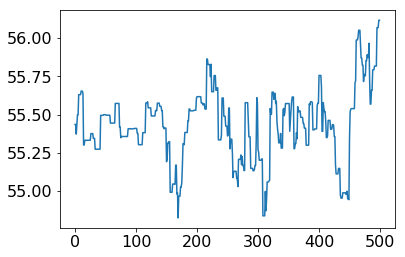

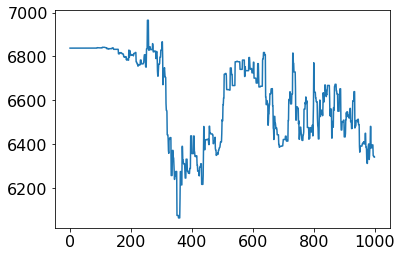

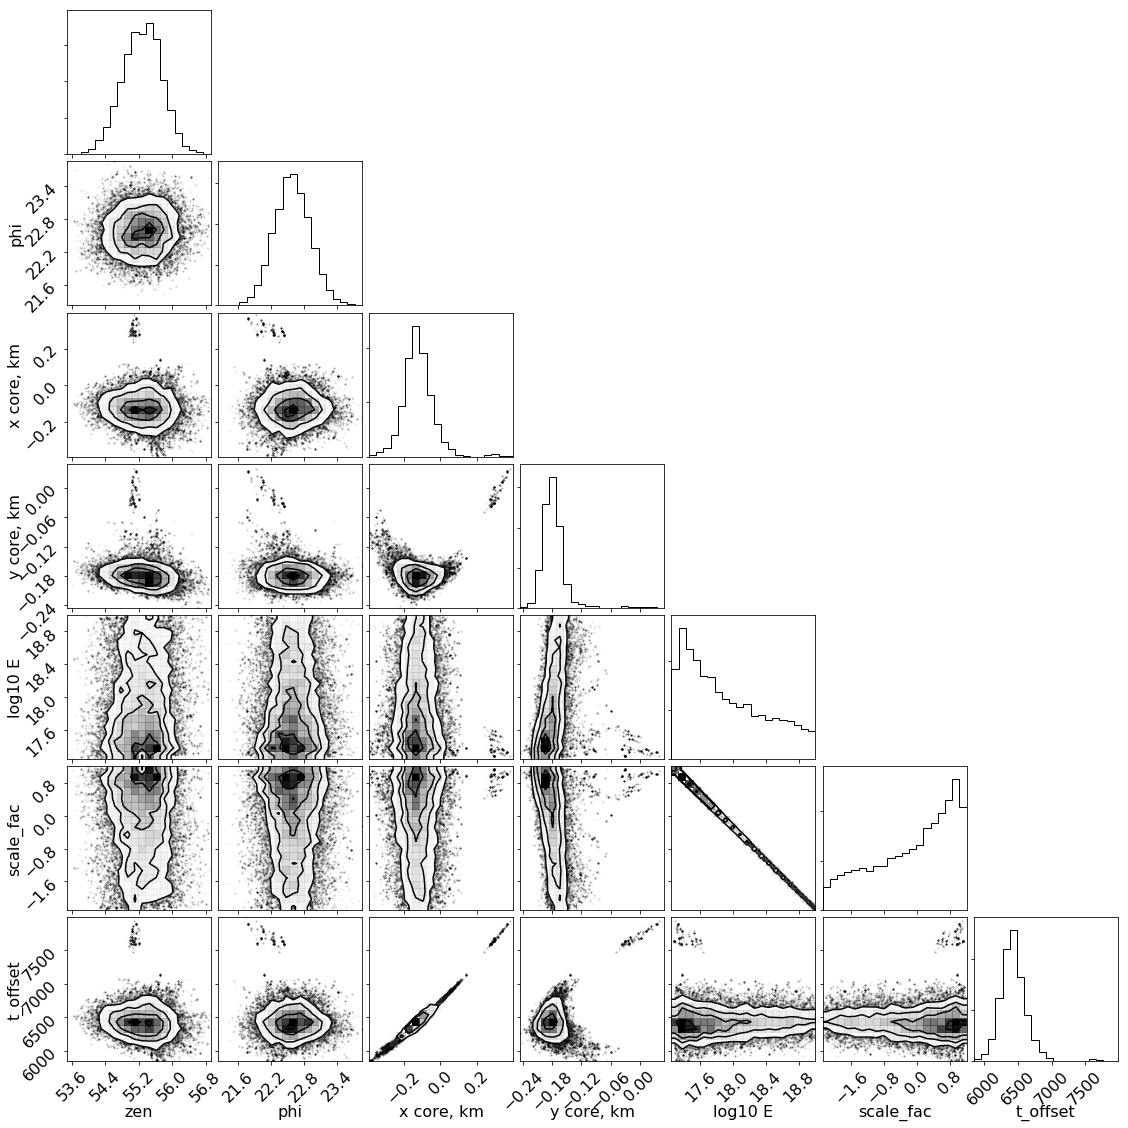

In [20]:
import corner
figure()
plot(sampler.chain[0,ntrials//2:,0], '-')
#plot(sampler.chain[1,:,0], '-')
#plot(sampler.chain[2,:,0], '-')
#plot(sampler.chain[3,:,0], '-')
#print sampler.chain[0,:,0]
samples = sampler.chain[:, ntrials//2:, :].reshape((-1, ndim))
print 'sampler.chain.shape', sampler.chain.shape
print 'sampler.lnprobability.shape', sampler.lnprobability.shape
ll_vals = sampler.lnprobability[:, ntrials//2:].reshape((-1))
print 'samples.shape, ll_vals.shape', samples.shape, ll_vals.shape
#samples = sampler.chain[:, 5000:, :].reshape((-1, ndim))

for k in range(ndim):
    print np.min(samples[:,k]), np.max(samples[:,k])

print 'sampler.chain.shape', sampler.chain.shape
print 'samples.shape', samples.shape
#import corner
figure()
#for k in range(0, len(sampler.chain)):
for k in range(0, 1):
    plot(sampler.chain[k,:,6])
'''
figure()
for k in np.random.randint(0, len(samples), 10):
    subplot(211)
    x0, y0, z0, a, b = samples[k,:]
    r2 = np.sqrt((x2-x0)**2 + (y2-y0)**2 + (z2-z0)**2)
    plot(r2, t2, 'o')
    plot(r2, hype(x_data, x0, y0, z0, a, b), '.', alpha=0.1)
    plot(r2, t2, 'kx', ms=10)
    subplot(212)
    plot(r2, hype(x_data, x0, y0, z0, a, b)-t2, '.', alpha=1.)
    #subplot(212)
    #plot([np.sum((hype(x_data, x0, y0, z0, a, b)-t2)**2)/float(len(t2)-5.)], '.')

figure()
plot(samples[:,0],samples[:,3], '.')
figure()
plot(samples[:,0],samples[:,4], '.')
#figure()
#hist(samples[:,1])
#figure()
#hist(samples[:,2])
#figure()
#hist(samples[:,3])
#figure()
#hist(samples[:,4])
'''
fig = corner.corner(samples, labels=['zen', 'phi', 'x core, km', 'y core, km', 'log10 E', 'scale_fac', 't_offset'])
fig.savefig("corner_ev_%d.png"%evnum)



[  5.54351368e+01   2.28710849e+01  -8.91783963e-02  -1.84849234e-01
   1.79799975e+01  -2.33326628e-01   6.50598243e+03]


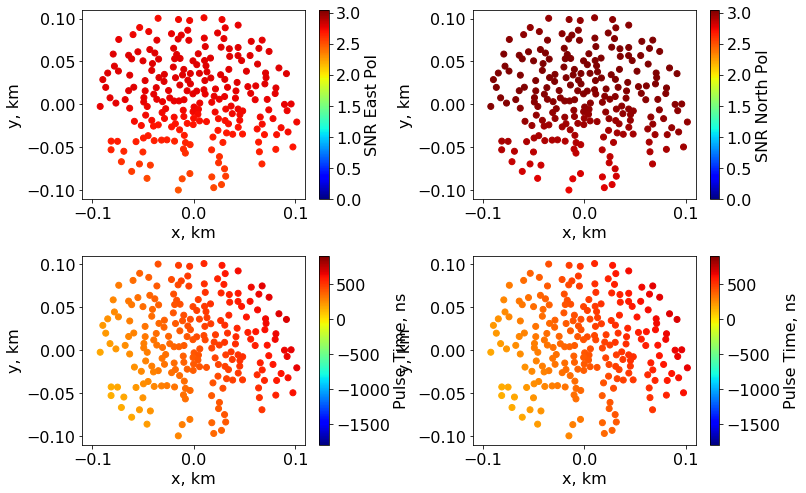

In [21]:
parms = samples[np.random.randint(0,len(samples)), :]
idx = np.argmax(ll_vals.shape)
parms = samples[idx, :]
print parms
log10_snr_x, log10_snr_y, delays = model(parms[0], parms[1], parms[2], parms[3], parms[4], show_plot=True)
#plot_event(ant_x, ant_y, ant_z, pows_x, time_x, pows_y, time_y, cluster=True)

parms[2], parms[3] -0.0891783963015 -0.184849234416
107.853679084 307.378133274
parms[2], parms[3] -0.0891783963015 -0.184849234416
parms[5] -0.233326628129
1.0281442693
post_t_med_x, post_t_MAD_x, 3.*t_RMS_x nan nan nan
post_t_med_y, post_t_MAD_y, 3.*t_RMS_y -0.430337028258 6.15468088833 45.6246494252
[  5.55748420e+01   2.26314267e+01   3.46416283e-02  -1.69739769e-01
   1.79302254e+01  -1.18385853e-01   6.83775820e+03]
[  3.85389259e+02  -4.46109147e+00   8.87969286e+01   8.99999852e+01
   9.13845940e+02   1.86297943e-01]


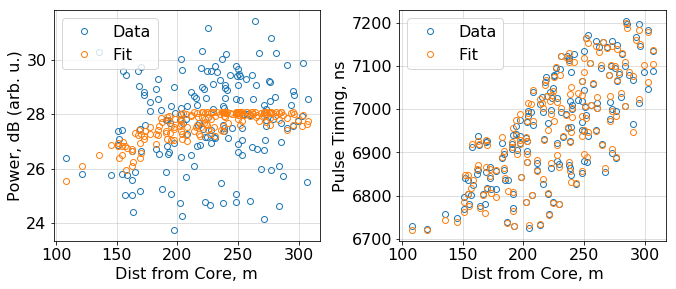

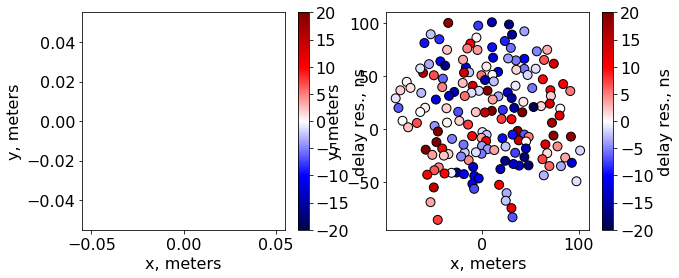

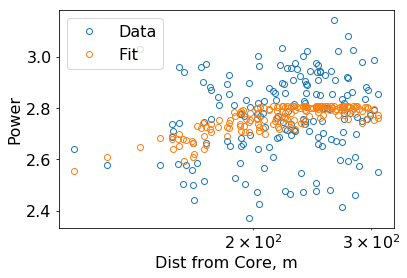

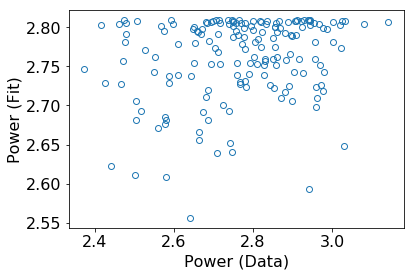

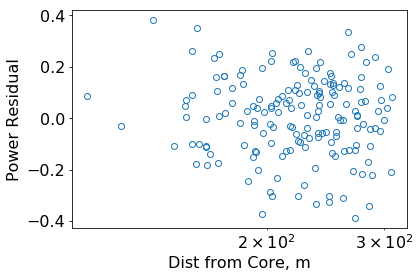

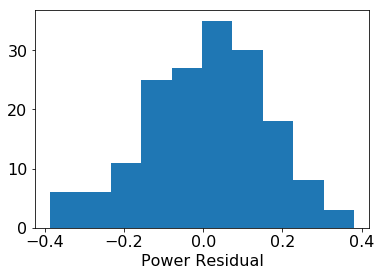

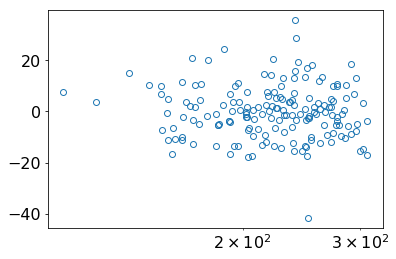

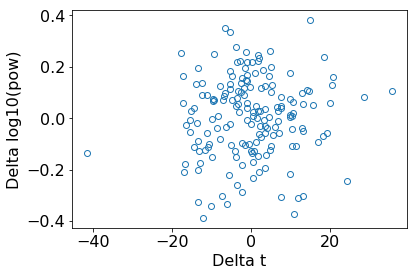

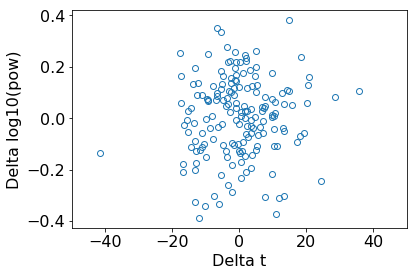

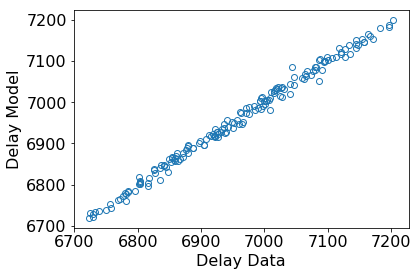

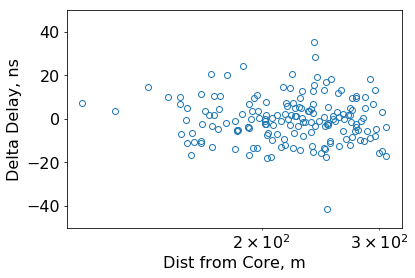

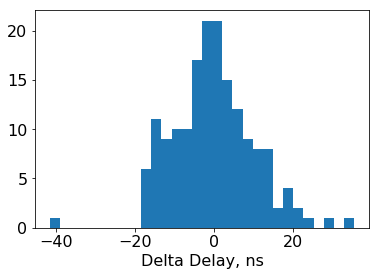

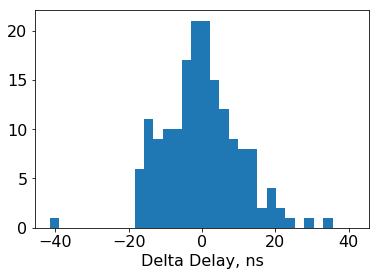

In [22]:
#idx = np.random.randint(len(samples))
#parms = samples[idx, :]

figure(figsize=(10,4))
subplot(121)
print 'parms[2], parms[3]', parms[2], parms[3]
r = np.sqrt((ant_x-parms[2]*1.e3)**2 + (ant_y-parms[3]*1.e3)**2)
#r = np.sqrt((ant_x)**2 + (ant_y)**2)
#semilogx(r, np.log10(pows_y), '.')
plot(r[qcut_y], 10.*np.log10(pows_y)[qcut_y], 'o', mfc='none', label='Data')
plot(r[qcut_y], 10.*(log10_snr_y[qcut_y]+parms[5]), 'o', mfc='none', label='Fit')
legend(loc=0)
#xticks([np.min(r[qcut_y]), np.max(r[qcut_y])])
grid(True, which='both', alpha=0.5)
xlabel('Dist from Core, m')
ylabel('Power, dB (arb. u.)')
#title('Event %d'%evnum)
print np.min(r[qcut_y]), np.max(r[qcut_y])
subplot(122)
plot(r[qcut_y], 5.*time_y[qcut_y], 'o', mfc='none', label='Data')
plot(r[qcut_y], delays[qcut_y]+parms[6], 'o', mfc='none', label='Fit')
legend(loc=0)
grid(True, which='both', alpha=0.5)
xlabel('Dist from Core, m')
ylabel('Pulse Timing, ns')
#title('Event %d'%evnum)
subplots_adjust(wspace=0.3, left=0.1, right=0.95, bottom=0.15, top=0.95)
savefig('event_%d_fit.pdf'%evnum)

figure(figsize=(10,4))
subplot(121)
scatter(ant_x[qcut_x], ant_y[qcut_x], c = (5.*time_x[qcut_x] - (delays[qcut_x]+parms[6])), 
        s=80, vmin=-20, vmax=20, cmap='seismic', edgecolors='k')
#plot(ant_x[qcut_y], ant_y[qcut_y], 'o', ms=10, mfc='none', mec='k') 
colorbar(label='delay res., ns')
xlabel('x, meters')
ylabel('y, meters')

subplot(122)
scatter(ant_x[qcut_y], ant_y[qcut_y], c = (5.*time_y[qcut_y] - (delays[qcut_y]+parms[6])), 
        s=80, vmin=-20, vmax=20, cmap='seismic', edgecolors='k')
#plot(ant_x[qcut_y], ant_y[qcut_y], 'o', ms=10, mfc='none', mec='k') 
colorbar(label='delay res., ns')
xlabel('x, meters')
ylabel('y, meters')
#plot( 5.*time_y[qcut_y] - (delays[qcut_y]+parms[6]))

figure()
print 'parms[2], parms[3]', parms[2], parms[3]
r = np.sqrt((ant_x-parms[2]*1.e3)**2 + (ant_y-parms[3]*1.e3)**2)
#r = np.sqrt((ant_x)**2 + (ant_y)**2)
#semilogx(r, np.log10(pows_y), '.')
semilogx(r[post_qcut_y], np.log10(pows_y)[post_qcut_y], 'o', mfc='none', label='Data')
semilogx(r[post_qcut_y], log10_snr_y[post_qcut_y]+parms[5], 'o', mfc='none', label='Fit')
legend(loc=0)
xlabel('Dist from Core, m')
ylabel('Power')

figure()
plot(np.log10(pows_y)[post_qcut_y], log10_snr_y[post_qcut_y]+parms[5], 'o', mfc='none')
ylabel('Power (Fit)')
xlabel('Power (Data)')
print 'parms[5]', parms[5]
print scaling_factor_0
figure()
semilogx(r[post_qcut_y], np.log10(pows_y)[post_qcut_y]-log10_snr_y[post_qcut_y]-parms[5], 'o', mfc='none')
xlabel('Dist from Core, m')
ylabel('Power Residual')

figure()
hist(np.log10(pows_y)[post_qcut_y]-log10_snr_y[post_qcut_y]-parms[5])
xlabel('Power Residual')


figure()
semilogx(r[post_qcut_y], 5.*time_y[post_qcut_y]-delays[post_qcut_y]-parms[6], 'o', mfc='none')

figure()
plot(5.*time_y[post_qcut_y]-delays[post_qcut_y]-parms[6], np.log10(pows_y)[post_qcut_y]-log10_snr_y[post_qcut_y]-parms[5], 'o', mfc='none')
xlabel('Delta t')
ylabel('Delta log10(pow)')

figure()
plot(5.*time_y[post_qcut_y]-delays[post_qcut_y]-parms[6], np.log10(pows_y)[post_qcut_y]-log10_snr_y[post_qcut_y]-parms[5], 'o', mfc='none')
xlabel('Delta t')
ylabel('Delta log10(pow)')
xlim(-50., 50.)


figure()
plot(5.*time_y[post_qcut_y], delays[post_qcut_y]+parms[6], 'o', mfc='none')
xlabel('Delay Data')
ylabel('Delay Model')


figure()
semilogx(r[post_qcut_y], 5.*time_y[post_qcut_y]-delays[post_qcut_y]-parms[6], 'o', mfc='none')
ylim(-50., 50.)
xlabel('Dist from Core, m')
ylabel('Delta Delay, ns')
figure()
hist(5.*time_y[post_qcut_y]-delays[post_qcut_y]-parms[6], bins=30)
xlabel('Delta Delay, ns')

post_t_med_x = np.median(5.*time_x[post_qcut_x]-delays[post_qcut_x]-parms[6])
post_t_MAD_x = np.median(np.abs(5.*time_x[post_qcut_x]-delays[post_qcut_x]-parms[6] - post_t_med_x))
post_t_med_y = np.median(5.*time_y[post_qcut_y]-delays[post_qcut_y]-parms[6])
post_t_MAD_y = np.median(np.abs(5.*time_y[post_qcut_y]-delays[post_qcut_y]-parms[6] - post_t_med_y))

print 'post_t_med_x, post_t_MAD_x, 3.*t_RMS_x', post_t_med_x, post_t_MAD_x, 5.*1.4826*post_t_MAD_x
print 'post_t_med_y, post_t_MAD_y, 3.*t_RMS_y', post_t_med_y, post_t_MAD_y, 5.*1.4826*post_t_MAD_y

figure()
hist(5.*time_y[post_qcut_y]-delays[post_qcut_y]-parms[6], bins=30)
#xlim(-50., 50.)
xlim(-5.*1.4826*post_t_MAD_y, 5.*1.4826*post_t_MAD_y)
xlabel('Delta Delay, ns')

print par_0
print dat['x2'][evnum]
#, time_x, pows_y, time_y)

len(chi_vals) 338
np.mean(chi_vals), np.std(chi_vals) 0.013048797344 1.0524488511


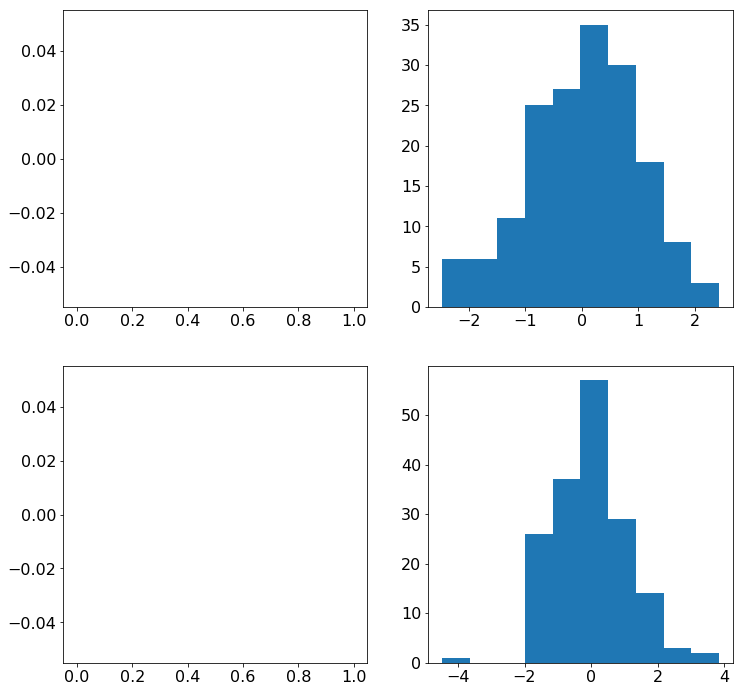

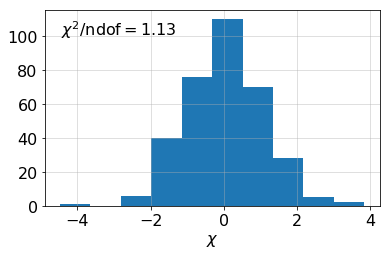

In [23]:
chi_p_x = (np.log10(pows_x)[post_qcut_x] - log10_snr_x[post_qcut_x] - parms[5])/(pow_x_err[post_qcut_x])
chi_p_y = (np.log10(pows_y)[post_qcut_y] - log10_snr_y[post_qcut_y] - parms[5])/(pow_y_err[post_qcut_y])
chi_t_x = (5.*time_x[post_qcut_x]-delays[post_qcut_x]-parms[6])/time_x_err[post_qcut_x]
chi_t_y = (5.*time_y[post_qcut_y]-delays[post_qcut_y]-parms[6])/time_y_err[post_qcut_y]

chi_vals = []
chi_vals = np.concatenate([chi_vals, chi_p_x])
chi_vals = np.concatenate([chi_vals, chi_p_y])
chi_vals = np.concatenate([chi_vals, chi_t_x])
chi_vals = np.concatenate([chi_vals, chi_t_y])

figure(figsize=(12,12))
subplot(221)
hist(chi_p_x)
subplot(222)
hist(chi_p_y)
subplot(223)
hist(chi_t_x)
subplot(224)
hist(chi_t_y)

#ll += -0.5*(np.sum((pows_2[qcut_y] - log10_snr_y[qcut_y] - scaling_factor)**2/(pow_y_err[qcut_y])**2))
#ll += -0.5*(np.sum((5.*time_1[qcut_x] - delays[qcut_x] - timing_offset)**2/(time_x_err[qcut_x])**2))
#ll += -0.5*(np.sum((5.*time_2[qcut_y] - delays[qcut_y] - timing_offset)**2/(time_y_err[qcut_y])**2))

figure()
print 'len(chi_vals)', len(chi_vals)
print 'np.mean(chi_vals), np.std(chi_vals)', np.mean(chi_vals), np.std(chi_vals)
chisq_ndof = np.sum(chi_vals**2)/float(len(chi_vals)-7.)
hist(chi_vals, label= r'$\chi^2/\mathrm{ndof}=%1.2f$'%chisq_ndof)
#legend(loc=2)
txt = r'$\chi^2/\mathrm{ndof}=%1.2f$'%chisq_ndof
y1, y2 = ylim()
x1, x2 = xlim()
text(x1 + 0.05*(x2-x1), 0.9*y2, txt, horizontalalignment='left', verticalalignment='center')
xlabel('$\chi$')
grid(True, which='both', alpha=0.5)
subplots_adjust(bottom=0.2)
savefig('chi_ev_%d.pdf'%evnum)

In [ ]:
 

>> 


%bannedInds: discard all data from these (one-indexed) input indices
   493
   494
   495
   496
   497
   498
   499
   500
   501
   502
   503
   504
   505
   506
   507
   508
   509
   510
   511
   512
   113
   114
   115
   116
   117
   118
   119
   120
   121
   122
   123
   124
   125
   126
   127
   128
   241
   242
   243
   244
   245
   246
   247
   248
   249
   250
   251
   252
   253
   254
   255
   256
   369
   370
   371
   372
   373
   374
   375
   376
   377
   378
   379
   380
   381
   382
   383
   384
   477
   478
   479
   480
   481
   482
   483
   484
   485
   486
   487
   488
   489
   490
   491
   492
